## DATA AUGMENTATION

Generación de datos sintéticos

In [1]:
# Importamos librerías

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
import keras

### Carga de dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# Averiguando la cantidad de clases

num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Cogemos una imagen del conjunto de datos y la utilizamos para demostrar el aumento de datos.

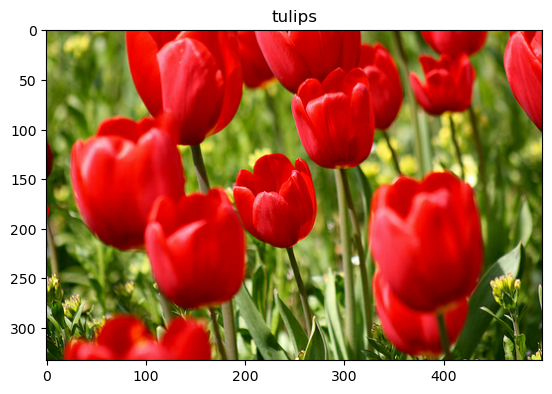

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Usar las capas de preprocesamiento de Keras

### Redimensionamiento y reescalado.

Es posible usar las capas de preprocesamiento de Keras para cambiar el tamaño de sus imágenes a una forma consistente (con tf.keras.layers.Resizing ) y para cambiar la escala de los valores de píxeles (con tf.keras.layers.Rescaling ).  

En el ejemplo, se redimensiona y reescala la imagen utilizando Keras Sequential y capas de aumento de imagen. Primero se redimensiona la imagen a 180 × 180 y luego se reescala en 1/255. El pequeño tamaño de la imagen servirá para ahorrar tiempo, memoria y computación. 

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

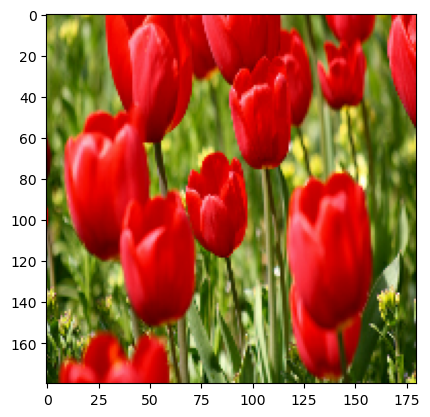

In [6]:
result = resize_and_rescale(image)
# plt.axis('off')
plt.imshow(result);

In [7]:
# Si interesa, es posible verificar que los píxeles esten en el rango [0, 1]
print("Valores de píxeles mínimos y máximos: ", result.numpy().min(), result.numpy().max())

Valores de píxeles mínimos y máximos:  0.0 1.0


## Aumento de datos

También se puede usar las capas de preprocesamiento de Keras para el aumento de datos, como **tf.keras.layers.RandomFlip** y **tf.keras.layers.RandomRotation**.

A continuación, se van a crear algunas capas de preprocesamiento y aplicarlas repetidamente a la misma imagen.

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [9]:
image = tf.expand_dims(image, 0)

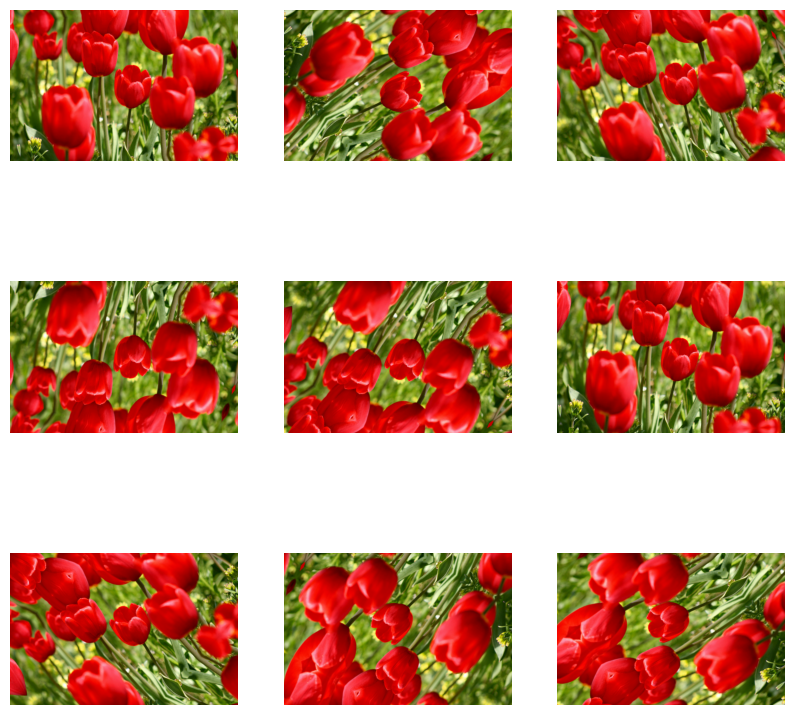

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.imshow(augmented_image[0].numpy()/255)
  plt.axis("off")

*Nota*: Si aparece la advertencia "WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers.", se puede intentar convertir la imagen a numpy y dividirla entre 255. Se mostrará el resultado claro en lugar de una imagen desvaída. 

Además del simple aumento, también puedes aplicar a las imágenes *RandomContrast*, *RandomCrop*, *HeightCrop*, *WidthCrop* y *RandomZoom*. 

## Añadir Data Augmentation directamente a la capa del modelo 

Hay dos formas de aplicar el aumento a las imágenes: 

1. El primer método consiste en añadir directamente las capas de aumento al modelo.

In [65]:
model = keras.Sequential([
  # Capas de preprocesado.
  resize_and_rescale,
  data_augmentation,
  # Capas del modelo.
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Resto de capas del modelo
])

Hay dos puntos importantes a tener en cuenta en este caso:

- El aumento de datos se ejecutará en el dispositivo, de forma sincronizada con el resto de sus capas, y se beneficiará de la aceleración de la GPU.
- Cuando exporta su modelo usando *model.save*, las capas de preprocesamiento se guardarán junto con el resto del modelo. Si luego se implementa este modelo, automáticamente estandarizará las imágenes (según la configuración de sus capas). Esto puede ahorrar el esfuerzo de tener que volver a implementar esa lógica del lado del servidor.

*Nota*: El aumento de datos está inactivo durante la fase de prueba. Solo funcionará para **Model.fit** (entrenamiento), no para **Model.evaluate** ni **Model.predict**

2. Aplicación de la función de aumento usando **.map**. En esta ocasión , se aplica el aumento de datos a todo el conjunto de entrenamiento usando la función *Dataset.map*

In [73]:
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

Con este enfoque, se utiliza *Dataset.map* para crear un conjunto de datos que produce lotes de imágenes aumentadas.   
En este caso:

- El aumento de datos ocurrirá de forma asíncrona en la CPU y no bloqueará. Puede superponer el entrenamiento de su modelo en la GPU con el preprocesamiento de datos, utilizando *Dataset.prefetch*, que se muestra a continuación.
- En este caso, las capas de preprocesamiento no se exportarán con el modelo cuando llame a *Model.save*. Deberá adjuntarlos a su modelo antes de guardarlo o volver a implementarlos en el lado del servidor. Después del entrenamiento, puede adjuntar las capas de preprocesamiento antes de exportar.

## Preprocesamiento de datos

Crearemos una función de preprocesamiento de datos para procesar los conjuntos de entrenamiento, validación y prueba. 

La función hará lo siguiente:

1. Aplicar el redimensionado y reescalado a todo el conjunto de datos.
2. Si shuffle es True, transpondrá el conjunto de datos.
3. Convierte los datos en lotes utilizando el tamaño de lote 32. 
4. Si augment es True, aplicará la función de aumento de datos en todos los conjuntos de datos. 
5. Por último, utiliza Dataset.prefetch para solapar el entrenamiento de tu modelo en la GPU con el procesamiento de los datos.

In [11]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds = prepare(train_ds, shuffle=True, augment=True)

In [13]:
val_ds = prepare(val_ds)

In [14]:
test_ds = prepare(test_ds)

## ENTRENAR UN MODELO

Para completar, ahora entrenará un modelo utilizando los conjuntos de datos que acaba de preparar.

El modelo secuencial consta de tres bloques de convolución (*tf.keras.layers.Conv2D*) con una capa de agrupación máxima (*tf.keras.layers.MaxPooling2D*) en cada uno de ellos. Hay una capa totalmente conectada (*tf.keras.layers.Dense*) con 128 unidades encima que se activa mediante una función de activación de ReLU (*'relu'*).    
El siguiente modelo no ha sido ajustado para precisión (el objetivo es mostrar la mecánica).

In [20]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


Aplicamos el optimizador *tf.keras.optimizers.Adam* y la función de pérdida *tf.keras.losses.SparseCategoricalCrossentropy*. Para ver la precisión del entrenamiento y la validación para cada época de entrenamiento, se pasa el argumento de *metrics* a **Model.compile**.

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Se entrena el modelo

In [19]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 5)

### Evaluación del modelo

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

## Aumento de datos personalizado
También es posible crear capas de aumento de datos personalizadas.

Tenemos dos formas de hacerlo:

- Primero, creará una capa **tf.keras.layers.Lambda**. Esta es una buena manera de escribir código conciso.
- A continuación, escribirá una nueva capa a través de *subclases*, lo que le brinda más control.   

Ambas capas invertirán aleatoriamente los colores de una imagen, según alguna probabilidad.

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

A continuación, se implementa una capa personalizada usando subclases:

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [ ]:
plt.imshow(RandomInvert()(image)[0])